In [1]:
import warnings

warnings.filterwarnings(
    "ignore",
)
import os

os.environ["NIXTLA_ID_AS_COL"] = "true"
import numpy as np

np.set_printoptions(suppress=True)
np.random.seed(1)
import random

random.seed(1)
import pandas as pd

pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)
import seaborn as sns
from utilsforecast.plotting import plot_series as plot_series_utils

sns.set_style("whitegrid")
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.rcParams.update(
    {
        "figure.figsize": (8, 5),
        "figure.dpi": 100,
        "savefig.dpi": 300,
        "figure.constrained_layout.use": True,
        "axes.titlesize": 12,
        "axes.labelsize": 10,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
        "legend.title_fontsize": 10,
    }
)

# Define a harmonious palette (8 colors)
ggplot_palette = [
    "#E24A33",  # orange-red
    "#348ABD",  # blue
    "#988ED5",  # purple
    "#777777",  # gray
    "#FBC15E",  # yellow
    "#8EBA42",  # green
    "#FFB5B8",  # pink
    "#17BECF",  # cyan
]

# Apply the palette globally
sns.set_palette(ggplot_palette)

from functools import partial

import matplotlib as mpl
from fpppy.utils import plot_series
from IPython.display import Image
from sklearn.metrics import root_mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL
from utilsforecast.evaluation import evaluate
from utilsforecast.feature_engineering import pipeline, trend
from utilsforecast.losses import mae
from utilsforecast.losses import mape as _mape
from utilsforecast.losses import mase, mqloss, quantile_loss, rmse


def mape(df, models, id_col="unique_id", target_col="y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include="number").columns] *= 100
    return df_mape


from fpppy.models import LinearRegression
from sklearn.linear_model import ElasticNet, LinearRegression
from statsforecast import StatsForecast
from statsforecast.models import (
    HistoricAverage,
    Naive,
    RandomWalkWithDrift,
    SeasonalNaive,
    SklearnModel,
    WindowAverage,
)
from statsforecast.utils import ConformalIntervals

In [2]:
df = pd.read_csv("../DATA/vic_elec.csv")
df["ds"] = pd.to_datetime(df.ds)
df = df.set_index("ds")
df = df[(df.index.month == 1) & (df.index.year == 2014)]
demand = df[df.unique_id == "Demand"].y.resample("D").sum().rename("electricity")
temperature = (
    df[df.unique_id == "Temperature"].y.resample("D").max().rename("temperature")
)
df = pd.concat([demand, temperature], axis=1)

<Axes: xlabel='ds', ylabel='electricity'>

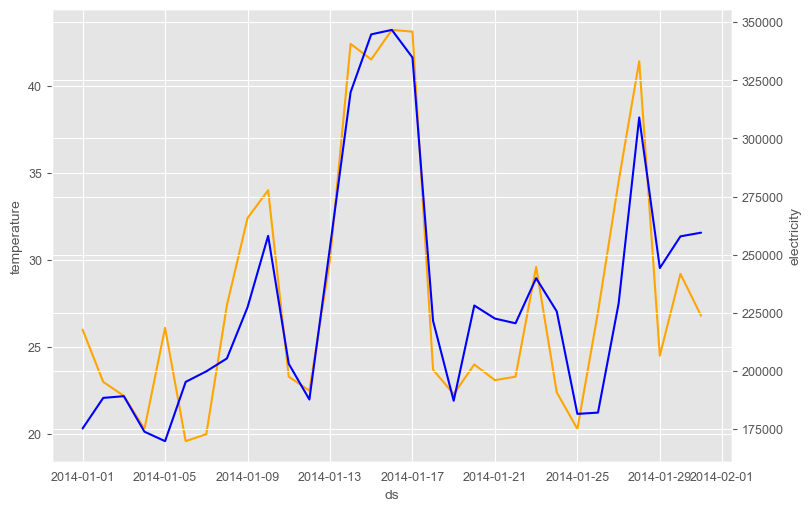

In [3]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
sns.lineplot(df, x=df.index, y=df.temperature, ax=ax1, color="orange")
sns.lineplot(df, x=df.index, y=df.electricity, ax=ax2, color="blue")

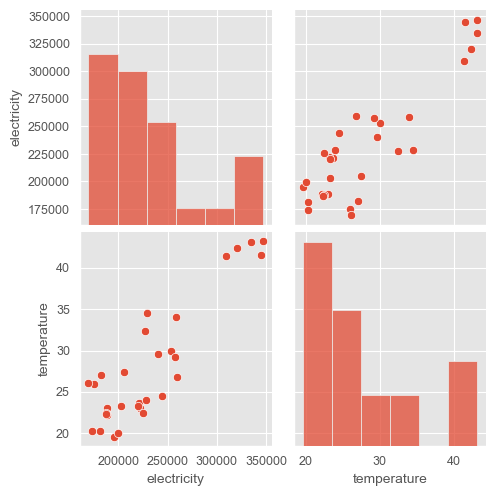

In [4]:
sns.pairplot(df)

In [8]:
X = df.temperature.values.reshape(-1, 1)
y = df.electricity.values.reshape(-1, 1)
reg = LinearRegression().fit(X, y)

In [32]:
def compute_std_resid(resid, k):
    T = len(resid)
    return np.sqrt(np.sum(np.square(resid)) / (T - k - 1))


def conf_intervals(x, X_train, resid, k=1):
    T = len(resid)
    x_mean = np.mean(X_train)
    x_std = np.std(X_train)
    std_resid = compute_std_resid(resid, k)
    tmp = 1 + (1 / T) + np.square(x - x_mean) / ((T - 1) * np.square(x_std))
    res = 1.96 * std_resid * np.sqrt(tmp)
    return res

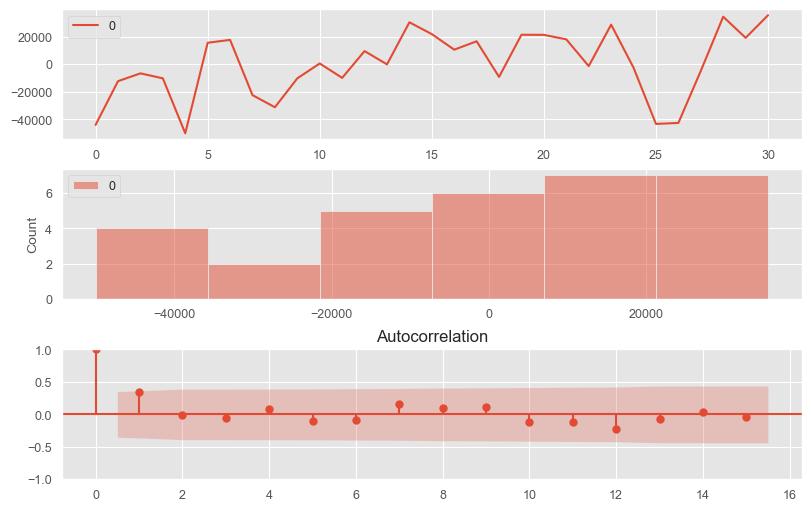

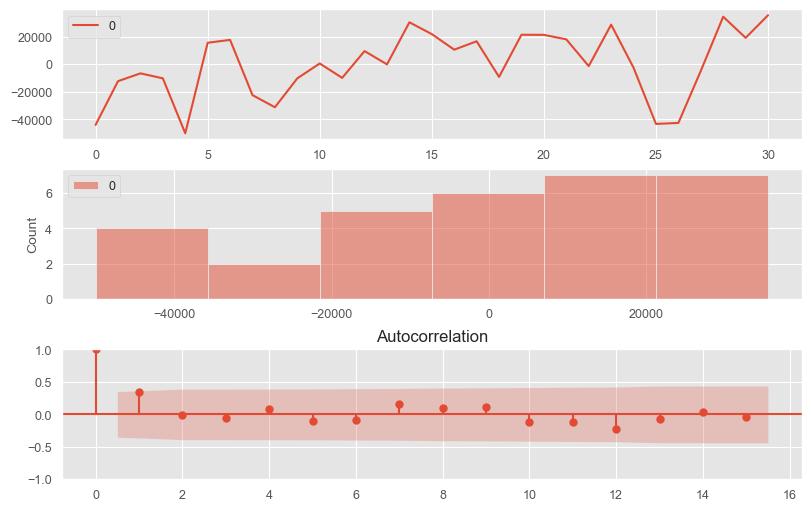

In [25]:
resid = y - reg.predict(X)
fig, axes = plt.subplots(3, 1)

sns.lineplot(resid, ax=axes[0])
sns.histplot(resid, ax=axes[1])
plot_acf(resid, ax=axes[2])

In [39]:
to_predict = 15
conf_interval = conf_intervals(to_predict, X, resid)
prediction = reg.predict(np.array(to_predict).reshape(1, 1))[0][0]
prediction - conf_interval, prediction, prediction + conf_interval

(100101.74528217532, 151398.35120729328, 202694.95713241125)

In [40]:
to_predict = 35
conf_interval = conf_intervals(to_predict, X, resid)
prediction = reg.predict(np.array(to_predict).reshape(1, 1))[0][0]
prediction - conf_interval, prediction, prediction + conf_interval

(224915.51815591243, 274484.246886576, 324052.9756172396)

In [42]:
df = pd.read_csv("../DATA/vic_elec.csv")
df["ds"] = pd.to_datetime(df.ds)
df = df.set_index("ds")
demand = df[df.unique_id == "Demand"].y.resample("D").sum().rename("electricity")
temperature = (
    df[df.unique_id == "Temperature"].y.resample("D").max().rename("temperature")
)
df = pd.concat([demand, temperature], axis=1)

<Axes: xlabel='temperature', ylabel='electricity'>

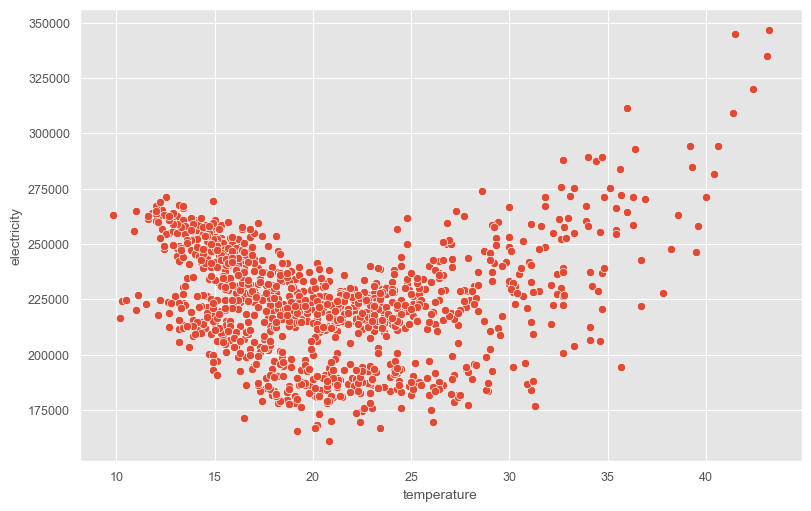

In [45]:
sns.scatterplot(df, x='temperature', y='electricity')